In [1]:
import baltic as bt
from matplotlib import pyplot as plt
from collections import defaultdict
from matplotlib import cm
from numpy import linspace
%matplotlib inline
import json
import matplotlib.gridspec as gridspec
import math
from itertools import combinations
import pandas as pd
import numpy as np
import seaborn as sns
from pprint import pprint
import math

/Library/Python/2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
regions = ['africa', 'europe', 'north_america', 'china', 'south_asia',
            'japan_korea', 'south_pacific', 'oceania', 'south_america',
            'southeast_asia', 'west_asia']

serotypes = ['denv1', 'denv2', 'denv3', 'denv4', 'all']
# serotypes = ['denv4']
genotypes = defaultdict(set)

def load_data(serotype):
    '''
    { 'denv2': 
        'tree': bt.tree,
        'frequencies': 
        {'south_america': 
            {'asianI': [ (1900, 0.2), (1920, 0.26), ....]},
        },
    }
    '''    
    tree = bt.loadJSON('/Users/Sidney/nextstrain/augur/dengue/auspice/dengue_%s_tree.json'%serotype) ## baltic Tree object
    all_frequencies = json.load(open('/Users/Sidney/nextstrain/augur/dengue/auspice/dengue_%s_frequencies.json'%serotype, 'r'))

    pivots = all_frequencies['pivots'] # add year (x vals)
    named_clade_frequencies = { clade : zip(pivots, freqs) 
                               for clade,freqs in all_frequencies.items() 
                               if clade!='pivots' and 'clade' not in clade } ## {'global:asianII':[(x,y)]}
    
    genotypes[serotype].update([i.split('_')[-1] for i in named_clade_frequencies.keys()])
    
    region_clade_frequencies = defaultdict(dict) ## {'global': {'asianII': [(x,y)] } }
    for regionclade, freqs in named_clade_frequencies.items():
            regionclade = regionclade.split('_')
            region, clade = '_'.join(regionclade[:-1]), regionclade[-1]
            region_clade_frequencies[region][clade] = freqs 
        
    return {'tree': tree, 'frequencies': region_clade_frequencies}

data = {serotype: load_data(serotype) for serotype in serotypes}

def assign_genotype_colors(serotype):
    ''' { 'denv2': {'asianI': viridis[0], ...}}'''
    clades = sorted(list(genotypes[serotype])) # ['asianI', 'american', ...]
    cm_subsection = linspace(0, 1, len(clades)) # [0, 0.2, 0.4, ...]
    colors = [ cm.viridis(x) for x in cm_subsection ] # [viridis[0], viridis[0.2], ...]
    cmap = { clade: color for (clade, color) in zip(clades, colors)} # {'asianI': viridis[0], ...}
    return cmap

colors = { serotype: assign_genotype_colors(serotype) for serotype in serotypes }
# { serotype: {clade: color} }

def assign_genotype_attr(tree):
    ''' Finds the most basal node with each genotype annotation, 
    propagates the genotype assignment to its monophyletic descendents'''
    have_clade_names = [ node for node in tree.Objects if 'clade_name' in node.traits ]
    for node in have_clade_names:
        for child in tree.traverse_tree(node, include_all=True):
            child.traits['clade_name'] = node.traits['clade_name']

for serotype in serotypes:
    assign_genotype_attr(data[serotype]['tree'])


Tree height: 111.832790
Tree length: 3018.549880
annotations present

Numbers of objects in tree: 642 (309 nodes and 333 leaves)


Tree height: 171.270610
Tree length: 2627.324510
annotations present

Numbers of objects in tree: 799 (380 nodes and 419 leaves)


Tree height: 72.013650
Tree length: 1408.189000
annotations present

Numbers of objects in tree: 473 (220 nodes and 253 leaves)


Tree height: 163.492310
Tree length: 1639.583360
annotations present

Numbers of objects in tree: 306 (149 nodes and 157 leaves)


Tree height: 403.899800
Tree length: 8993.814080
annotations present

Numbers of objects in tree: 1603 (767 nodes and 836 leaves)



In [3]:
print data.keys()
print data['denv4'].keys()
print data['denv4']['frequencies'].keys()
print data['denv4']['frequencies']['south_america'].keys()
print data['denv4']['frequencies']['south_america']['I'][:5]

print colors

['denv4', 'denv2', 'denv3', 'all', 'denv1']
['frequencies', 'tree']
[u'europe', u'south_pacific', u'oceania', u'south_america', u'africa', u'global', u'southeast_asia', u'china', u'south_asia', u'japan_korea', u'west_asia', u'north_america']
[u'I', u'II', u'SYLVATIC']
[(1917.5, 0.0611), (1917.5833, 0.0611), (1917.6667, 0.0611), (1917.75, 0.0611), (1917.8333, 0.0611)]
{'denv4': {u'I': (0.26700400000000002, 0.0048739999999999999, 0.32941500000000001, 1.0), u'II': (0.12756799999999999, 0.56694900000000004, 0.55055600000000005, 1.0), u'SYLVATIC': (0.99324800000000002, 0.90615699999999999, 0.14393600000000001, 1.0)}, 'denv2': {u'ASIAN-I': (0.19063099999999999, 0.40706100000000001, 0.55608900000000006, 1.0), u'AMERICAN': (0.26700400000000002, 0.0048739999999999999, 0.32941500000000001, 1.0), u'ASIAN/AMERICAN': (0.20802999999999999, 0.71870100000000003, 0.47287299999999999, 1.0), u'COSMOPOLITAN': (0.99324800000000002, 0.90615699999999999, 0.14393600000000001, 1.0)}, 'denv3': {u'II': (0.267004

In [4]:
def plot_region_frequencies(serotype, region, data=data):
    plt.title(region)
    plt.xlabel('Year')
    plt.ylabel('Genotype Frequency')

    for clade, frequencies in data[serotype]['frequencies'][region].items():
        x, y = zip(*frequencies) # [(x,y)] --> [(x1,x2,x3), (y1,y2,y3)]
        plt.plot(x,y, color=colors[serotype][clade], label=clade)
        
def plot_tree(serotype):
    branchWidth=2 ## default branch width
    ll = data[serotype]['tree']

    for k in ll.Objects: ## iterate over objects in tree
        x=k.absoluteTime ## or use absolute time instead
        y=k.y ## get y position from .drawTree that was run earlier, but could be anything else

        xp=k.parent.absoluteTime ## get x position of current object's parent
        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        c= colors[serotype][k.traits['clade_name']] if k.traits.has_key('clade_name') else 'k'

        if isinstance(k,bt.leaf) or k.branchType=='leaf': ## if leaf...
            s=50 ## tip size can be fixed
            s=50-30*k.height/ll.treeHeight

            plt.scatter(x,y,s=s,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every tip
            plt.scatter(x,y,s=s+0.8*s,facecolor='k',edgecolor='none',zorder=10) ## plot black circle underneath
        elif isinstance(k,bt.node) or k.branchType=='node': ## if node...
            plt.plot([x,x],[k.children[-1].y,k.children[0].y],lw=branchWidth,color=c,ls='-',zorder=9)

        plt.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)
        plt.title(serotype)

def plot_frequencies_and_tree(serotype):
    sns.set_style('whitegrid')
    fig = plt.figure(figsize=(11,8.5))
    gs = gridspec.GridSpec(4,5, width_ratios=[1,1,1,1,3], )
    
    globe = plt.subplot(gs[0, :-1])
    plot_region_frequencies(serotype, 'global')
    plt.legend(loc=(0,-4.5), title="Genotypes of %s"%serotype, )
    globe.set_ylim([0, 1])

    north_america = plt.subplot(gs[1,0])
    plot_region_frequencies(serotype, 'north_america')
    north_america.set_ylim([0, 1])
    
    europe = plt.subplot(gs[1, 1])
    plot_region_frequencies(serotype, 'europe')
    europe.set_ylim([0, 1])

    china = plt.subplot(gs[1,2])
    plot_region_frequencies(serotype, 'china')
    china.set_ylim([0, 1])

    japan_korea = plt.subplot(gs[1,3])
    plot_region_frequencies(serotype, 'japan_korea')
    japan_korea.set_ylim([0, 1])
    
    south_america = plt.subplot(gs[2,0])
    plot_region_frequencies(serotype, 'south_america')
    south_america.set_ylim([0, 1])

    africa = plt.subplot(gs[2,1])
    plot_region_frequencies(serotype, 'africa')
    africa.set_ylim([0, 1])

    south_asia = plt.subplot(gs[2,2])
    plot_region_frequencies(serotype, 'south_asia')
    south_asia.set_ylim([0, 1])
    
    southeast_asia = plt.subplot(gs[2,3])
    plot_region_frequencies(serotype, 'southeast_asia')
    southeast_asia.set_ylim([0, 1])
    
    south_pacific = plt.subplot(gs[3,2])
    plot_region_frequencies(serotype, 'south_pacific')
    south_pacific.set_ylim([0, 1])
    
    oceania = plt.subplot(gs[3,3])
    plot_region_frequencies(serotype, 'oceania')
    oceania.set_ylim([0, 1])
    
    sns.set_style('white')
    treeplot = plt.subplot(gs[:,-1])
    plot_tree(serotype)
        
    plt.tight_layout()
    plt.show()

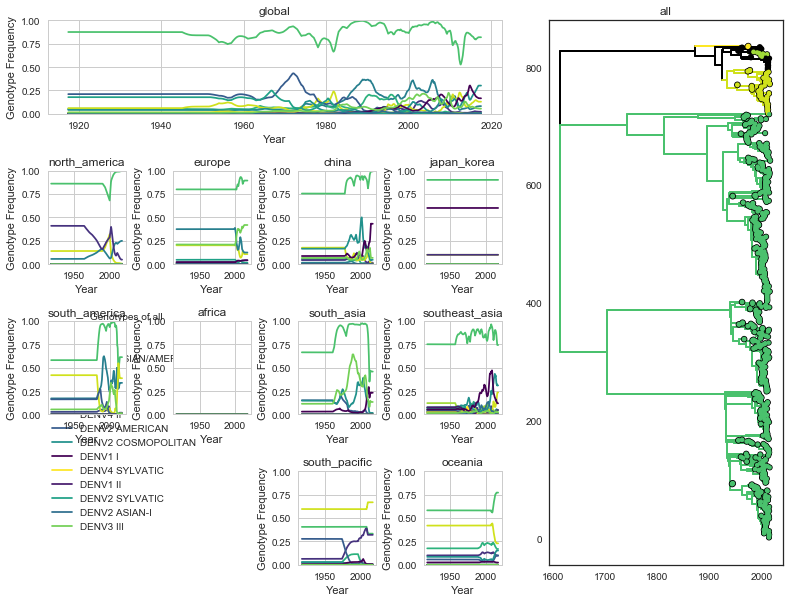

In [4]:
plot_frequencies_and_tree('all')

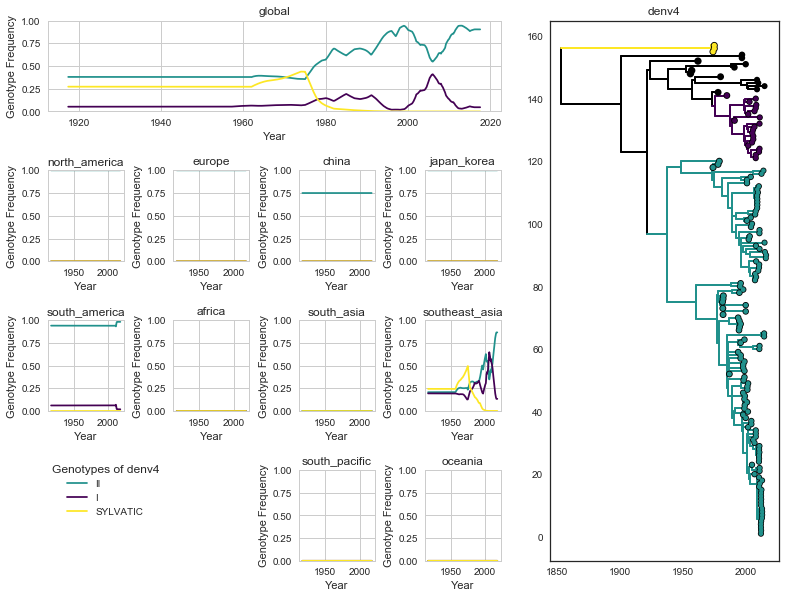

In [10]:
plot_frequencies_and_tree('denv4')

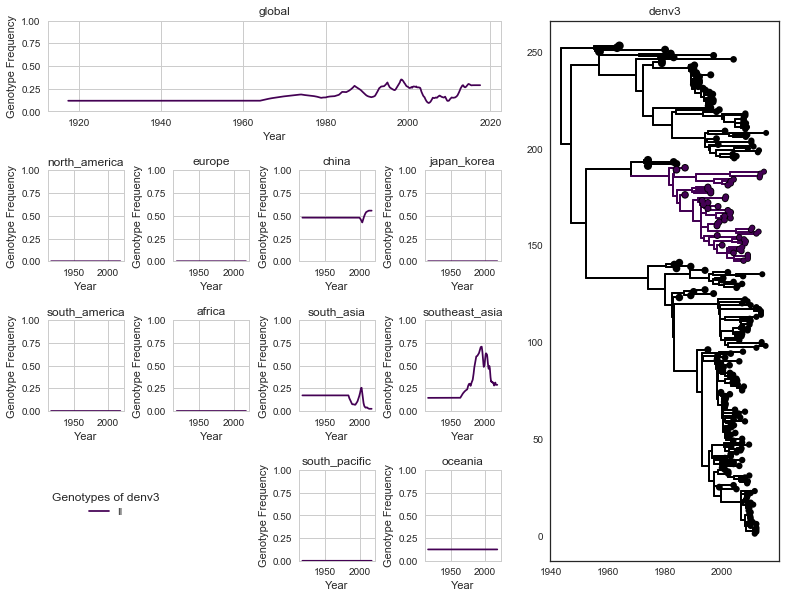

In [11]:
plot_frequencies_and_tree('denv3')

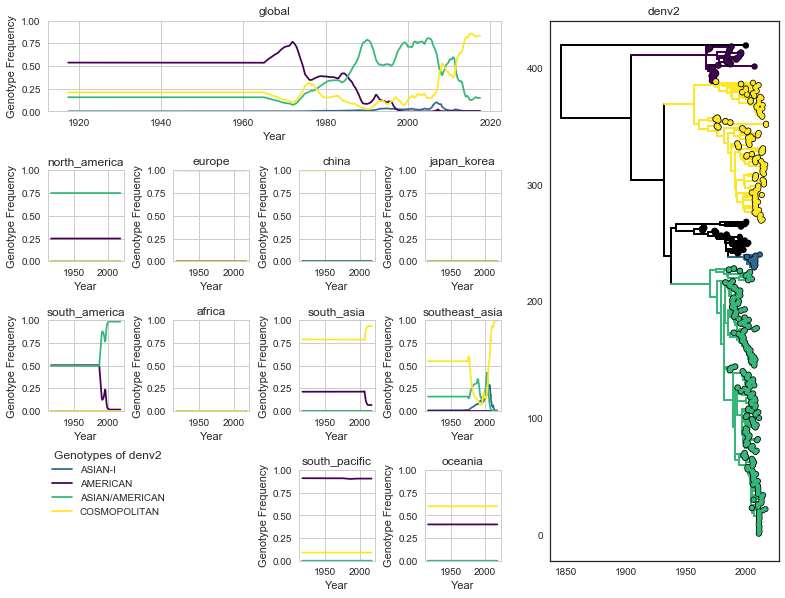

In [12]:
plot_frequencies_and_tree('denv2')

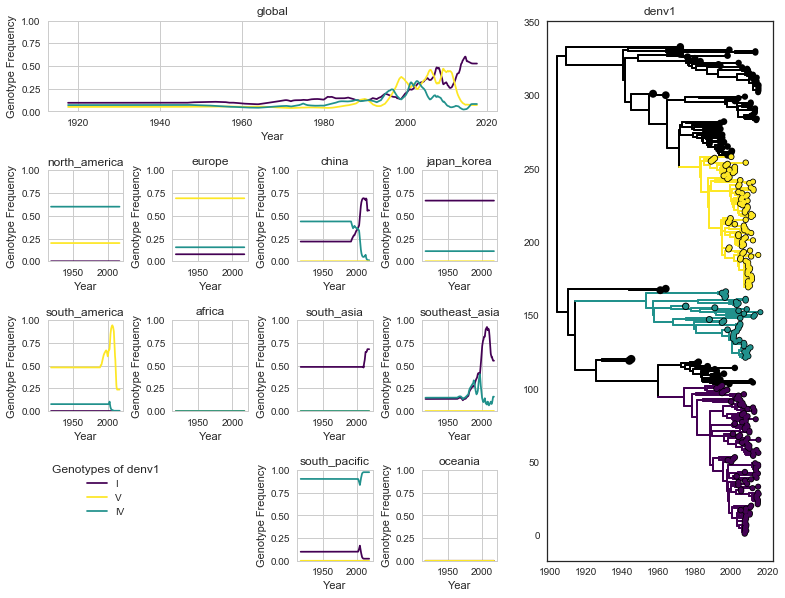

In [13]:
plot_frequencies_and_tree('denv1')

In [9]:
def calculate_r(xlist, ylist):
    assert len(xlist) == len(ylist), 'unequal number of x and y values'
    sum_x_squared = sum([ x**2 for x in xlist ])
    sum_x = sum(xlist)
    
    sum_y_squared = sum([ y**2 for y in ylist ])
    sum_y = sum(ylist)
    
    sum_xy = sum([ x*y for x,y in zip(xlist,ylist) ])
    n = len(xlist)
    
    r = ((n*sum_xy) - (sum_x*sum_y)) / np.sqrt( ((n*sum_x_squared) - (sum_x**2))*(n*sum_y_squared - (sum_y**2)) )

    try:
        assert -1.0 <= r <= 1.0 ## Only fails when denominator approaches 0; returnin nan is appropriate.
        return r
    except:
        return np.nan

In [14]:
def compare_frequencies(serotype, region):

    genotype_frequencies = data[serotype]['frequencies'][region]
    
    for (g1, g2) in combinations(genotype_frequencies.keys(), 2):
        g1_frequencies = [y for x,y in genotype_frequencies[g1]]
        g2_frequencies = [y for x,y in genotype_frequencies[g2]]
        r = calculate_r(g1_frequencies, g2_frequencies)
        heatmap_df.at[g1, g2] = float('%.2f'%r)
    
    heatmap_df.fillna(0., inplace=True) ## Heatmaps can't handle missing data; use 0 to indicate no relationship.
    return heatmap_df



/Library/Python/2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in sqrt
/Library/Python/2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in double_scalars


In [5]:
def make_dataframe(serotype, region):
    ''' dataframe with genotypes as columns, pivots as index, region-specific frequencies as values'''
    subset_data = data[serotype]['frequencies'][region]
    pivots = [ i[0] for i in subset_data.values()[0] ]
    subset_data = { k: [i[1] for i in v] for k,v in subset_data.items()}
    df = pd.DataFrame(subset_data, index=pivots)
    return df

genotype_dfs = {}
for serotype in serotypes:
    genotype_dfs[serotype] = {}
    genotype_dfs[serotype]['global'] = make_dataframe(serotype, 'global')

    for region in regions:
        genotype_dfs[serotype][region] = make_dataframe(serotype, region)
        ''' { 'denv2': {'south_america': pd.DataFrame(columns=genotypes, index=pivots, values=frequencies) }}'''

In [6]:
def define_seasons(pivots):
    '''Returns tuples of numdates for 
    May - December dengue seasons for each year in pivots'''
    min_year = int(math.floor(min(pivots)))
    max_year = int(math.ceil(max(pivots)))
    seasons = [(year + 5./12., year + 364./365.) 
               for year in range(min_year, max_year)]
    return seasons #[(start, end), (start, end)]

pivots = [i[0] for i in data['denv4']['frequencies']['south_america'].values()[0]]
seasons = define_seasons(pivots)

def find_hyperendemic_seasons(seasons, serotype, region):
    '''
    Return a subset of the data from seasons where there were >= 2 genotypes 
    circulating in the region
    '''
    
    def bin_seasons(numdate):
        ''' Return (start, end) season numdate belongs in'''
        season = np.nan
        for start, end in seasons:
            if numdate >= start and numdate<= end:
                season = (start, end)
                break
        return season

    def is_hyperendemic(subset):
        ''' Return boolean of whether there were >2 genotypes 
        at >= 5% frequency on average during that season'''
        mean_frequencies = subset.mean()
        above_five_percent = mean_frequencies[mean_frequencies >= 0.05]
        return len(above_five_percent) >= 2 ## return boolean
        print above_five_percent
    
    df = genotype_dfs[serotype][region]
    pivots = pd.Series(df.index.values, index=df.index.values)
    df['season'] = pivots.map(bin_seasons)
    
    hyperendemic_seasons = []
    
    for season in seasons:
        if is_hyperendemic(df.loc[df['season'] == season]):
            hyperendemic_seasons.append(season)
    
    hyperendemic_frequencies = df.loc[df['season'].isin(hyperendemic_seasons)]
    return hyperendemic_frequencies

In [27]:
def intra_inter_serotype_pairs(frequencies, min_frequency = 0.05):
    above_min_frequency = frequencies[frequencies >= 0.05]
    cocirculating_genotypes = above_min_frequency.index.values
    cocirculating_serotypes = [i.split()[0] for i in cocirculating_genotypes]
    pairs = [i for i in combinations(cocirculating_serotypes, 2)]
    
    intraserotype = float(len([i for i in pairs if i[0]==i[1]]))
#     interserotype = float(len([i for i in pairs if i[0]!=i[1]]))
    total_pairs = float(len(pairs))
    return intraserotype / total_pairs

def map_intra_inter_serotype_pairs(df):
    proportion_intraserotype = df.apply(intra_inter_serotype_pairs, axis=1)
    mean_proportion_intraserotype = proportion_intraserotype.mean()
    return mean_proportion_intraserotype

def shuffle_labels(df):
    shuffled = df.copy()
    np.random.shuffle(shuffled.columns.values)
    return shuffled

In [32]:
def cocirculating(serotype, region, n = 1000):
    data = find_hyperendemic_seasons(seasons, serotype, region).groupby('season').agg('mean')

    c = map_intra_inter_serotype_pairs(data)

    null_distribution = []
    for i in range(n):
        shuffled_data = shuffle_labels(data)
        null_distribution.append(map_intra_inter_serotype_pairs(shuffled_data))
    
    return {'c': c, 'null_distribution': null_distribution}

In [34]:
cocirculating_in_south_america = cocirculating('all', 'south_america')

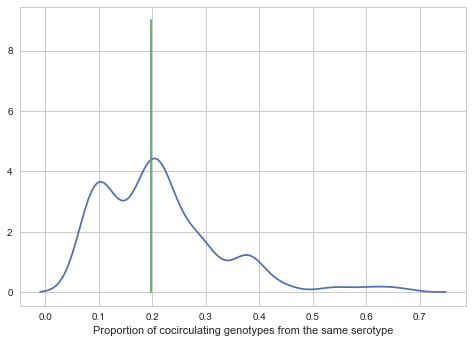

In [40]:
sns.set_style('whitegrid')
cocirculating_plot = sns.kdeplot(pd.Series(cocirculating_in_south_america['null_distribution']))
cocirculating_plot.plot([cocirculating_in_south_america['c'] for i in range(10)], [i for i in range(10)])
cocirculating_plot.set_xlabel('Proportion of cocirculating genotypes from the same serotype')
